In [42]:
import re
import nltk
from tokenize import tokenize
import spacy
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer;
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from collections import defaultdict


# Assignment 3 

In [43]:


def data_preprocessing(sentences, vectorizer=None):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    processed_words = []
    
    for sentence in sentences:
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        sentence = sentence.lower()
        tokens = word_tokenize(sentence)
        filtered_tokens = [word for word in tokens if word not in stop_words]
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
        processed_word = ' '.join(lemmatized_tokens)
        processed_words.append(processed_word)
    
    if vectorizer is None:
        # vectorizer = TfidfVectorizer()
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(processed_words)
    else:
        X = vectorizer.transform(processed_words)
    
    return X, vectorizer

## Question 1:Knowledge graph

In [44]:
import nltk
from nltk.chunk import ne_chunk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


def extract_relations_from_text_with_nltk(text):
    relations = []
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)
    stop_words = set(stopwords.words('english'))
    # Process each sentence
    for sentence in sentences:
        # Tokenize words in the sentence
        
        words = word_tokenize(sentence)
        words = [word for word in words if word not in stop_words]
        words = [word if word != 'I' else 'Sebastian' for word in words]
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        # words = [lemmatizer.lemmatize(word) for word in words]
        # Perform part-of-speech tagging
        
        # tagged_words = pos_tag(words)
        tagged_tokens = pos_tag(words)
        tagged_tokens = [(word, 'NNP') if word == 'Sebastian' else (word, tag) for word, tag in tagged_tokens]
        # Initialize variables to store entities and relation
        entity_one = []
        entity_two = []
        switch = False
        relation = None
        
        # Traverse tagged words to extract entities and relation
        for word, tag in tagged_tokens:
            # Check if the tag indicates a noun (entity)
            if tag.startswith('NN'):
                if switch == False:
                    entity_one.append(word)
                else :
                    entity_two.append(word)
            # Check if the tag indicates a verb (relation)
            elif tag.startswith('VB'):
                switch = True
                relation = word
        
        entity_one = " ".join(entity_one)
        entity_two = " ".join(entity_two)

        # If entities and relation are found, concatenate entities and append relation
        if entity_one and entity_two and relation:            
            relations.append((entity_one, relation, entity_two))  # Append relation between entities
        
    return relations

# # Example usage
text = "I received my PhD in Information Systems from Massey University in 2005. Then I was lecturing in Information Systems at Massey University, Palmerston North, until 2007. From 2008 until 2011, I was Associate Professor at the School of Information Management at the Victoria University of Wellington. In 2012, I joined the Department of Computer Science at the University of Auckland. I was awarded a Doctor of Science degree from the University of Auckland in 2015. I received the Chris Wallace Award for outstanding research contributions to Australia and New Zealand in 2013, awarded by the Computing Research and Education Association of Australasia (CORE). This is the most prestigious award for mid-career computer scientists in Australasia. The prize is available to academics for post-PhD research undertaken in a university or research institution in Australia or New Zealand. The research must include a notable breakthrough or contribution of particular significance. At most one award is made each year. Currently, I am an editorial board member of the journals Information Systems, Data and Knowledge Engineering, and Proceedings of the VLDB Endowment. I am reviewing extensively for other journals and conferences including ACM SIGMOD, ACM Transactions on Database System, IEEE ICDE, IEEE Transactions on Knowledge and Data Engineering, VLDB and the VLDB Journal."
relations = extract_relations_from_text_with_nltk(text)
print("Extracted Relations:")
for relation in relations:
     print( relation[0] + "-----" + relation[1] + "--->" +  relation[2])  
    

Extracted Relations:
Sebastian-----received--->PhD Information Systems Massey University
Sebastian-----lecturing--->Information Systems Massey University Palmerston North
Sebastian-----joined--->Department Computer Science University Auckland
Sebastian-----awarded--->Doctor Science degree University Auckland
Sebastian-----awarded--->Chris Wallace Award research contributions Australia New Zealand Computing Research Education Association Australasia CORE
research-----include--->contribution significance
award-----made--->year
Sebastian-----including--->journals conferences ACM SIGMOD ACM Transactions Database System IEEE ICDE IEEE Transactions Knowledge Data Engineering VLDB VLDB Journal


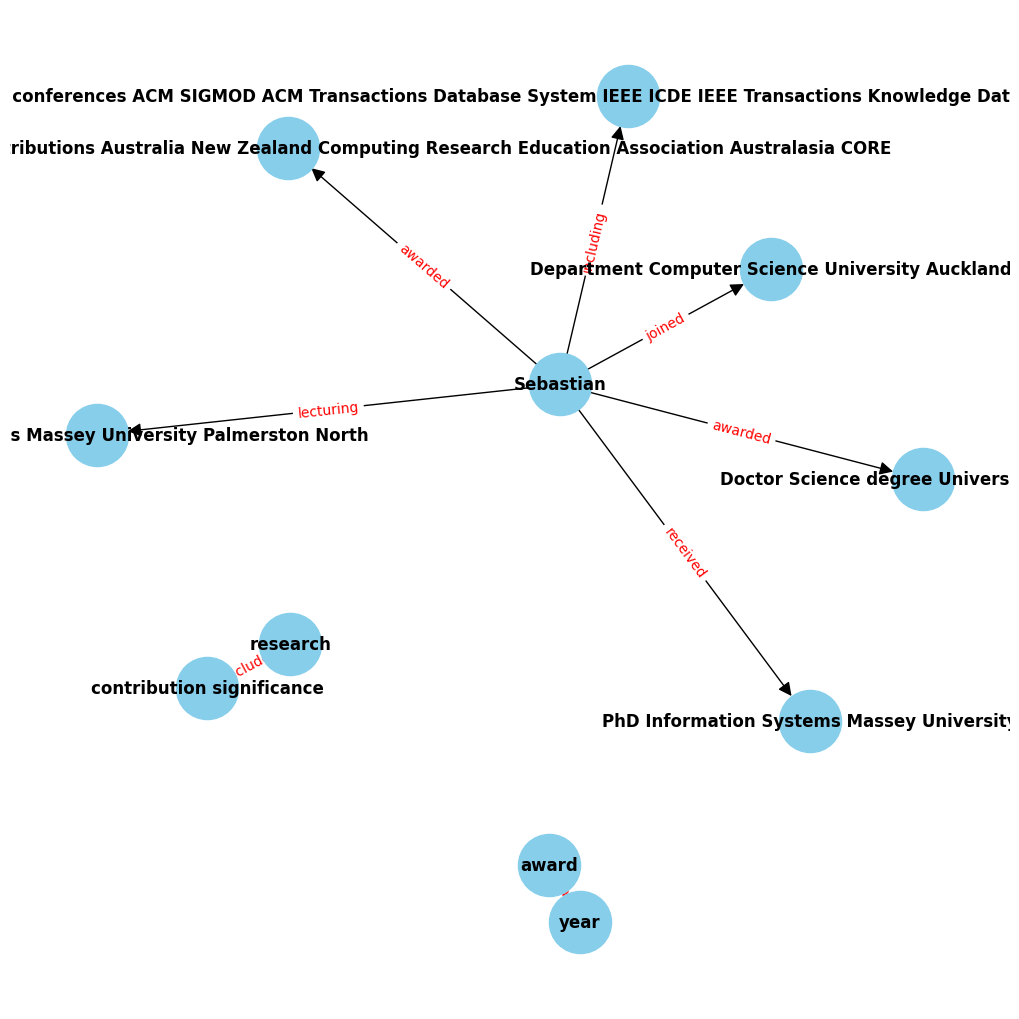

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add relations as edges to the graph
for relation in relations:
    G.add_edge(relation[0], relation[2], label=relation[1])

# Plot the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.show()

In [46]:
import spacy


def extract_relations_from_text_with_spacy(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    verbs = [token.lemma_ for token in doc if token.pos_ == "VERB"]

    knowledge_base = []

    for token in doc: 
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            subject = [child.text for child in token.children if child.dep_ in ("nsubj", "nsubjpass")]
            objects = [child.text for child in token.children if child.dep_ in ("dobj", "pobj")]
            for sub in subject:
                for obj in objects:
                    knowledge_base.append( (sub, token.lemma_, obj))
    return knowledge_base


text = "I received my PhD in Information Systems from Massey University in 2005. Then I was lecturing in Information Systems at Massey University, Palmerston North, until 2007. From 2008 until 2011, I was Associate Professor at the School of Information Management at the Victoria University of Wellington. In 2012, I joined the Department of Computer Science at the University of Auckland. I was awarded a Doctor of Science degree from the University of Auckland in 2015. I received the Chris Wallace Award for outstanding research contributions to Australia and New Zealand in 2013, awarded by the Computing Research and Education Association of Australasia (CORE). This is the most prestigious award for mid-career computer scientists in Australasia. The prize is available to academics for post-PhD research undertaken in a university or research institution in Australia or New Zealand. The research must include a notable breakthrough or contribution of particular significance. At most one award is made each year. Currently, I am an editorial board member of the journals Information Systems, Data and Knowledge Engineering, and Proceedings of the VLDB Endowment. I am reviewing extensively for other journals and conferences including ACM SIGMOD, ACM Transactions on Database System, IEEE ICDE, IEEE Transactions on Knowledge and Data Engineering, VLDB and the VLDB Journal."
relations = extract_relations_from_text_with_spacy(text)

print(relations)

[('I', 'receive', 'PhD'), ('I', 'join', 'Department'), ('I', 'award', 'degree'), ('I', 'receive', 'Award'), ('research', 'include', 'breakthrough')]


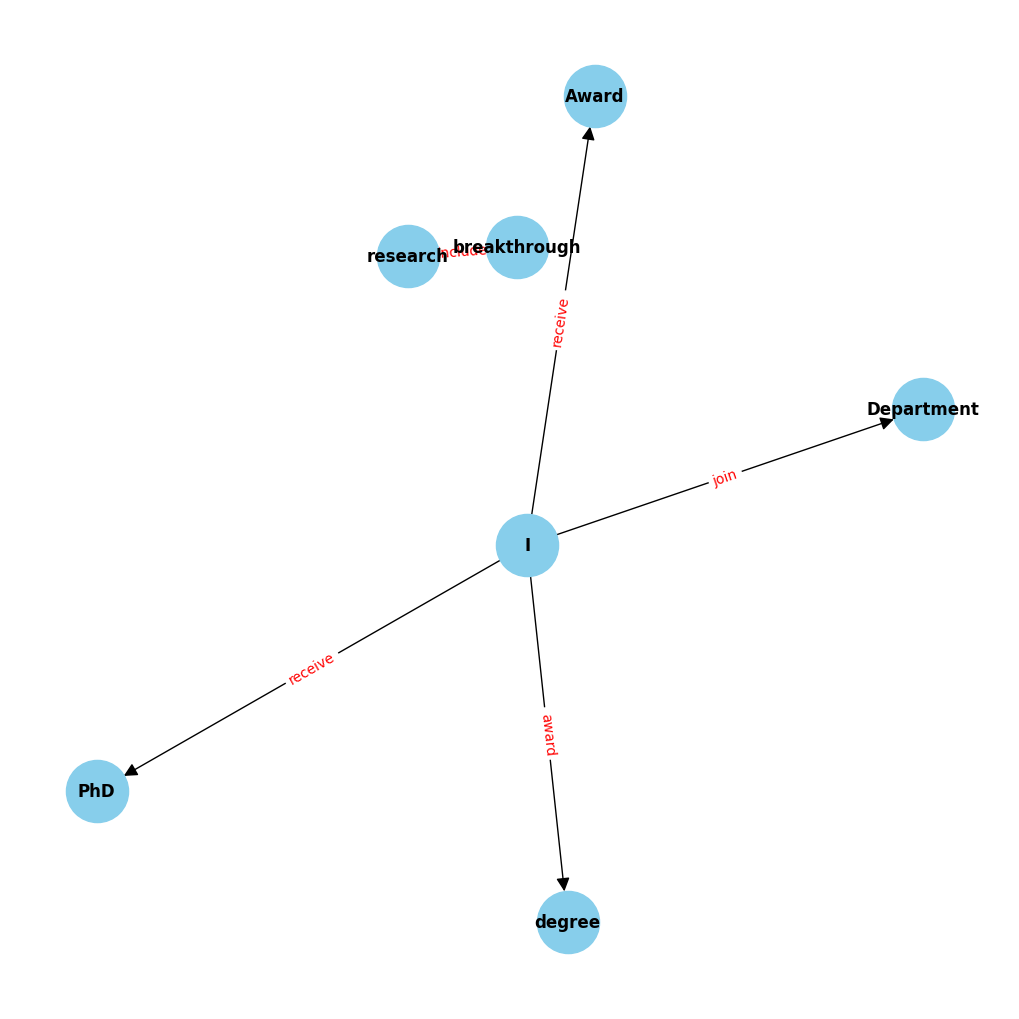

In [47]:
# Create a directed graph
G = nx.DiGraph()

# Add relations as edges to the graph
for relation in relations:
    G.add_edge(relation[0], relation[2], label=relation[1])

# Plot the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.show()

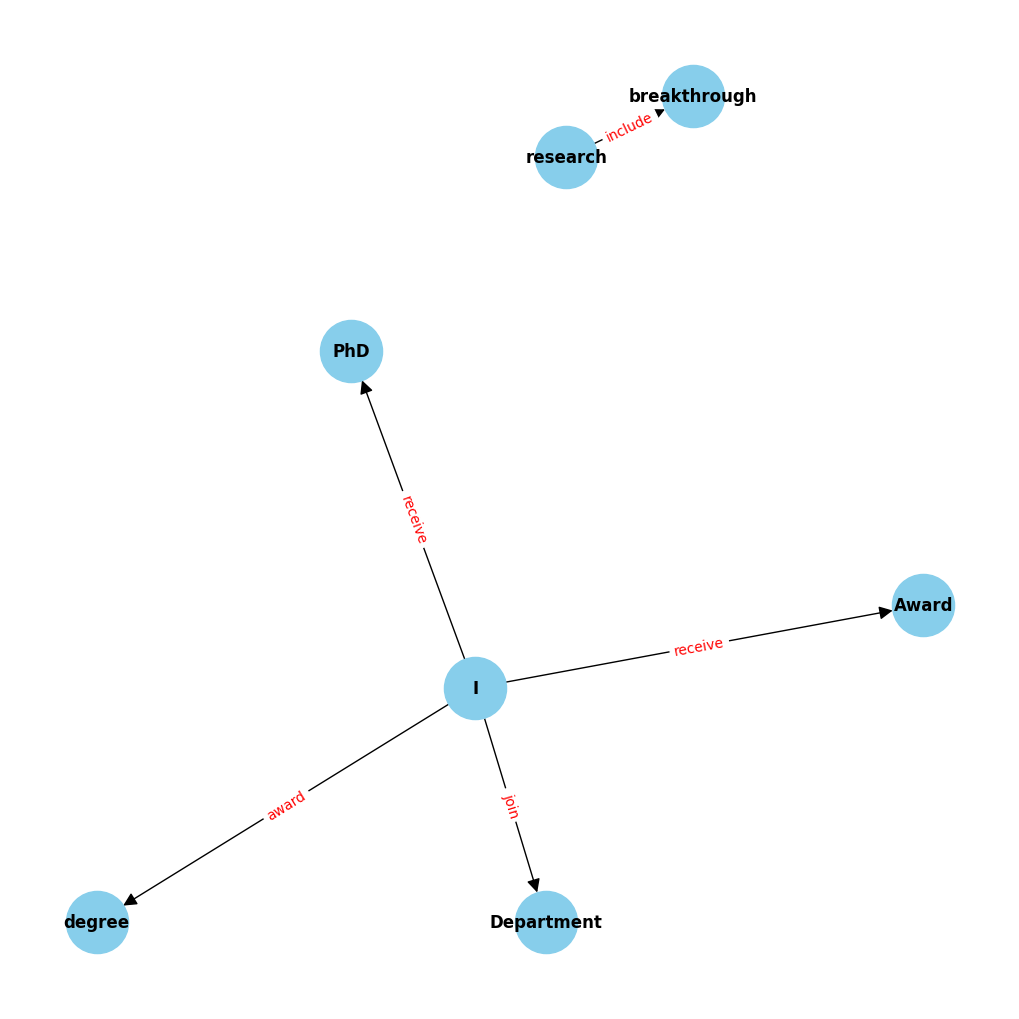

In [48]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt

def extract_relations_from_text_with_spacy(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    verbs = [token.lemma_ for token in doc if token.pos_ == "VERB"]

    knowledge_base = []

    for token in doc: 
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            subject = [child.text for child in token.children if child.dep_ in ("nsubj", "nsubjpass")]
            objects = [child.text for child in token.children if child.dep_ in ("dobj", "pobj")]
            for sub in subject:
                for obj in objects:
                    knowledge_base.append((sub, token.lemma_, obj))
    return knowledge_base

def refine_knowledge_graph(knowledge_base):
    refined_knowledge_base = []

    for triple in knowledge_base:
        subject, relation, obj = triple

        # Normalize relations
        relation = relation.lower()

        # Convert certain noun phrases to verbs
        if relation in ["received", "awarded"]:
            relation = "receive"
        
        refined_knowledge_base.append((subject, relation, obj))
    
    return refined_knowledge_base

text = "I received my PhD in Information Systems from Massey University in 2005. Then I was lecturing in Information Systems at Massey University, Palmerston North, until 2007. From 2008 until 2011, I was Associate Professor at the School of Information Management at the Victoria University of Wellington. In 2012, I joined the Department of Computer Science at the University of Auckland. I was awarded a Doctor of Science degree from the University of Auckland in 2015. I received the Chris Wallace Award for outstanding research contributions to Australia and New Zealand in 2013, awarded by the Computing Research and Education Association of Australasia (CORE). This is the most prestigious award for mid-career computer scientists in Australasia. The prize is available to academics for post-PhD research undertaken in a university or research institution in Australia or New Zealand. The research must include a notable breakthrough or contribution of particular significance. At most one award is made each year. Currently, I am an editorial board member of the journals Information Systems, Data and Knowledge Engineering, and Proceedings of the VLDB Endowment. I am reviewing extensively for other journals and conferences including ACM SIGMOD, ACM Transactions on Database System, IEEE ICDE, IEEE Transactions on Knowledge and Data Engineering, VLDB and the VLDB Journal."
relations = extract_relations_from_text_with_spacy(text)

# Refine the knowledge graph
refined_relations = refine_knowledge_graph(relations)

# Create a directed graph
G = nx.DiGraph()

# Add relations as edges to the graph
for relation in refined_relations:
    G.add_edge(relation[0], relation[2], label=relation[1])

# Plot the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
plt.show()


# Given two set A and B, the symmetric difference size between A and B is |A| + |B| −2|A ∩ B|. Consider 4 sets below:
- S1 = {1, 2, 4, 6, 8} ,
- S2 = {1, 2, 4, 6, 9} ,
- S3 = {1, 2, 4, 7, 9} ,
- S4 = {1, 3, 5, 7, 9} .

## Finding all pairs of sets such that their symmetric difference size is at most 2:


Symmetric difference :|A| + |B| −2|A ∩ B|<br>

S1 Δ S2 = |S1| + |S2| - 2|S1 ∩ S2| = 5 + 5 - 2(4) = 2<br>


S1 Δ S3 = |S1| + |S3| - 2|S1 ∩ S3| = 5 + 5 - 2(3)  = 4<br>


S1 Δ S4 = |S1| + |S4| - 2|S1 ∩ S4|= 5 + 5 - 2(1) = 8<br>


S2 Δ S3 |S2| + |S3| - 2|S2 ∩ S3| = 5 + 5 - 2(4)  = 2<br>

S2 Δ S4 = |S2| + |S4| - 2|S2 ∩ S4| = 5 + 5 - 2(2) = 6<br>

S3 Δ S4 = |S3| + |S4| - 2|S3 ∩ S4| = 5 + 5 - 2(3) = 4<br>


Pairs of set with symmetric difference size at 2 : <br>

{S1, S2} <br>
{S2, S3} <br>




## Using the hash function h(x) = x + 1 mod 4, construct odd sketches of 4 bits length for these sets above.

S1 {1, 2, 4, 6, 8} : <br>
h(1) = (1 + 1) mod 4 = 2 mod 4 = 2 <br>
h(2) = (3 + 1) mod 4 = 3 mod 4 = 3<br>
h(4) = (4 + 1) mod 4 = 5 mod 4 = 1<br>
h(6) = (6 + 1) mod 4 = 7 mod 4 = 3<br>
h(8) = (8 + 1) mod 4 = 9 mod 4 = 1<br>

odd(S1) = [0,0,1,0]<br>

S2 = {1, 2, 4, 6, 9}<br>

h(1) = (1 + 1) mod 4 = 2 mod 4 = 2 <br>
h(2) = (2 + 1) mod 4 = 3 mod 4 = 3 <br>
h(4) = (4 + 1) mod 4 = 5 mod 4 = 1<br>
h(6) = (6 + 1) mod 4 = 7 mod 4 = 3<br>
h(9) = (9 + 1) mod 4 = 10 mod 4 = 2<br>

odd(S2) = [0,1,0,0]<br>

S3 = {1, 2, 4, 7, 9}<br>

h(1) = (1 + 1) mod 4 = 2 mod 4 = 2<br>
h(2) = (2 + 1) mod 4 = 3 mod 4 = 3<br>
h(4) = (4 + 1) mod 4 = 5 mod 4 = 1<br>
h(7) = (7 + 1) mod 4 = 8 mod 4 = 0<br>
h(9) = (9 + 1) mod 4 = 10 + mod 4 = 2 <br>

odd(S3) = [1,1,0,1]<br>

S4 = {1, 3, 5, 7, 9}<br>
h(1) = (1 + 1) mod 4 = 2 mod 4 = 2 <br>
h(3) = (3 + 1) mod 4 = 4 mod 4 = 0 <br>
h(5) = (5 + 1) mod 4 = 6 mod 4 = 2 <br>
h(7) = (7 + 1) mod 4 = 8 mod 4 = 0 <br>
h(9) = (9 + 1) mod 4 = 10 mod 4 = 2<br>

S4 = [0,0,1,0]<br>


In [53]:

def my_hash(x):
    return (x + 1) % 4


sets = {
    'S1': {1, 2, 4, 6, 8},
    'S2': {1, 2, 4, 6, 9},
    'S3': {1, 2, 4, 7, 9},
    'S4': {1, 3, 5, 7, 9}
}


sketches = {key: [0]*4 for key in sets}


for key, s in sets.items():
    for item in s:
        index = my_hash(item)
        print(index)
        sketches[key][index] ^= 1  # XOR to flip the bit
    print("---")

sketches

2
3
1
3
1
---
2
3
1
3
2
---
2
3
1
0
2
---
2
0
2
0
2
---


{'S1': [0, 0, 1, 0],
 'S2': [0, 1, 0, 0],
 'S3': [1, 1, 0, 1],
 'S4': [0, 0, 1, 0]}

## How can we use these odd sketches to solve the question 1? Explain your solutio

Given sets: 
- odd(S1) [0,0,1,0]
- odd(S2) [0,1,0,0]
- odd(S3) [1,1,0,1]
- odd(S4) [0,0,1,0]

Output after using odd sketch.  
|odd(S1) Δ odd(S2)| = |[0,0,1,0] ⨁ [0,1,0,0]| =2<br>
|odd(S1) Δ odd(S3)| = |[0,0,1,0] ⨁ [1,1,0,1]| = 4<br>
|odd(S1) Δ odd(S4)| = |[0,0,1,0] ⨁ [0,0,1,0]| = 0 <br>
|odd(S2) Δ odd(S3)| = |[0,1,0,0] ⨁ [1,1,0,1]| =2<br>
|odd(S2) Δ odd(S4)| = |[0,1,0,0] ⨁ [0,0,1,0]| = 2<br>
|odd(S3) Δ odd(S4)| = |[1,1,0,1] ⨁ [0,0,1,0]| = 4<br>

We observe that the symmetric difference size is at most 2 for the following pairs of sets: {S1, S2}, {S2, S3}, {S2, S4}, and {S1, S4}.

However, upon further analysis, we find misclassifications. For instance, {S2, S4} is classified with a symmetric difference of 2, but its actual symmetric difference is 6, and {S1, S4} is classified with a symmetric difference of 0, whereas its actual symmetric difference is 8. This discrepancy suggests that the hash function used may not provide a sufficiently random distribution, which in turn affects the accuracy of solving for question 1.

In conclusion, the hash algorithm is not sufficiently random. Increasing the vector digit length may assist alleviate this issue.


# Page Rank
## Compute the transition matrix M for graph 1

| | A  | B | C | D | E|
|-|----|----|--|---|---|
|A| 0 |  0  | 0  |1/3 |1   |
|B| 1 |  0  |  1 | 0  | 0  |
|C|  0 | 1/2|  0 | 1/3|  0 |
|D|  0 | 1/2|  0 | 0  |   0|
|E|  0 | 0  |  0 | 1/3|  0 |

## Compute the PageRank of each vertex until it converges. 

Total iteration for coverage all 5 Vertex is 24 times, and each figure of vertex are :
- Vertex A: 0.12499985859863202
- Vertex B: 0.37500069212248505
- Vertex C: 0.2499997246394413
- Vertex D: 0.18749944927888273
- Vertex E: 0.06250027536055858



## Provide the Python script that computes the PageRank. 

In [49]:
import numpy as np

M = np.array([
    [0, 0, 0, 1/3, 1],
    [1, 0, 1, 0, 0],
    [0, 1/2, 0, 1/3, 0],
    [0, 1/2, 0, 0, 0],
    [0, 0, 0, 1/3, 0]
])

def page_rank(matrix, d, max_iter=100):
    # Initialize the pagerank score with uniform distribution
    num_nodes = matrix.shape[0]

    U = np.ones_like(matrix) / num_nodes
    v = np.ones(num_nodes) / num_nodes

    for i  in range(max_iter):
        pr = d * (matrix.dot(v)) + (1 - d) * v
        # print(pr)
        if np.allclose(v, pr):
            print("Iteration: %f" % i)
            break
        v = pr
    
    return v
   

result = page_rank(M, 1)
print("PageRank:")
for i, pr in enumerate(result):
    print(f"Vertex {chr(65+i)}: {pr}")


Iteration: 24.000000
PageRank:
Vertex A: 0.12499985859863202
Vertex B: 0.37500069212248505
Vertex C: 0.2499997246394413
Vertex D: 0.18749944927888273
Vertex E: 0.06250027536055858
